In [2]:
import sys
sys.path.append('../model/')

import pickle as pkl
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from tools import tools
import os

model_col_map = {'ce2': 'tab:purple',
                 'ce3': 'tab:green',
                 'ce4': 'tab:olive',
                 'ident': 'tab:blue',
                 'epf': 'black',
                 'epr': 'tab:red',
                 'add': 'tab:pink'}


## Line Plots

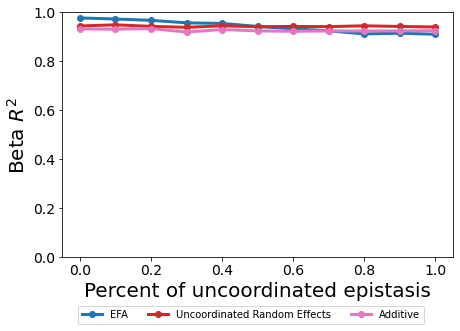

In [142]:
res = dict()
# fig, ax = plt.subplots(1, 1, sharey=True, sharex=True)

# param='additive_var'
# param='snp'
# param='N'
param='percent_uncoordinated'
# param='heritability'
# param = 'dominance'

# metric = 'pheno'
metric = 'beta'
# metric = 'omega'
# metric = 'u'

ylab = {'pheno': r'Phenotype Prediction $R^{2}$',
        'beta': r'Beta $R^{2}$',
        'omega': r'Omega $R^{2}$',
        'u': r'Epistasis Factor $R^{2}$'}
fontsize = 20
fig, ax = plt.subplots(figsize = (7, 5))
ax.set_ylabel(ylab[metric], size = fontsize)
if param == 'heritability':
    ax.set_xlabel(r'$H^{2}$', size = fontsize)
elif param == 'additive_var':
    ax.set_xlabel(r'Percent of $H^{2}$ that is additive', size = fontsize)
elif param == 'dominance':
    ax.set_xlabel(r'Percent of $H^{2}$ that is additive', size = fontsize)
elif param == 'percent_uncoordinated':
    ax.set_xlabel(r'Percent of uncoordinated epistasis', size = fontsize)
elif param == 'snp':
    ax.set_xlabel(r'$\log_{10}$(# of SNPs)', size = fontsize)
elif param == 'N':
    ax.set_xlabel(r'$\log_{10}$(# of samples)', size = fontsize)

ax.set_ylim((0, 1))

num_plots = 0
i = 2
prefix = './data/%s_k%d/' %(param, i)
for name in ['additive', 
             'uncoordinated', 'uncoordinated_random', 
             'coordinated_k2', 
             'coordinated_self_k2', 'coordinated_self_k3', 'coordinated_self_k4']:    
    df = pd.read_csv(prefix + name + '.csv')
    if param == 'snp' or param == 'N':
        df['param'] = np.log10(df['param'])
    if metric == 'beta':
        df = df[df.loc[:, 'beta'] != 0].groupby('param').mean()
    else: 
        df = df.groupby('param').mean()
    res[name] = df

ax.plot(res[f'coordinated_k2'].loc[:,metric],
    linestyle='-', marker='o', color=model_col_map['ident'], label=f'EFA', linewidth=3)
num_plots += 1

# for i in [2, 3, 4]:
#     ax.plot(res[f'coordinated_self_k{i}'].loc[:,metric], 
#         linestyle=':', marker='.', color=model_col_map[f'ce{i}'], label=f'K = {i}')
#     num_plots += 1

if metric != 'beta':
    ax.plot(res['uncoordinated'].loc[:,metric],
        linestyle='-', marker='o', color=model_col_map['epf'], label='Uncoordinated Fixed Effects', linewidth=3)
    num_plots += 1

ax.plot(res['uncoordinated_random'].loc[:,metric],
    linestyle='-', marker='o', color=model_col_map['epr'], label='Uncoordinated Random Effects', linewidth=3)
num_plots += 1

if metric == 'pheno' or metric == 'beta': 
    ax.plot(res['additive'].loc[:,metric], 
        linestyle='-', marker = 'o', 
        color = model_col_map['add'], label='Additive', linewidth=3)
    if metric == 'pheno':
        ax.set_ylim((0, 0.6))
        if param == 'N':
            ax.plot([2, 5], [0.5, 0.5], linestyle='--', color = 'black', label='h2', linewidth=2)
        else:
            ax.plot([0, 1], [0.5, 0.5], linestyle='--', color = 'black', label='h2', linewidth=2)
        if param == 'additive_var':
            ax.plot([0, 1], [0, 0.5], linestyle='--', color = model_col_map['add'], label='h2', linewidth=2)
        if param == 'percent_uncoordinated':
            ax.plot([0, 1], [0.25, 0.25], linestyle='--', color = model_col_map['add'], label='h2', linewidth=2)

    num_plots += 1
# ax.set_title('True K = %d' %(i))
fig.subplots_adjust(bottom=0.2)
fig.legend(loc='lower center', bbox_to_anchor=(0.5, 0),
          ncol=3, fancybox=True)
ax.tick_params(axis='both', which='major', labelsize=14)
# plt.tight_layout()

fig.savefig(f'./plots/{param}_{metric}_line.png', transparent=True, dpi=300)


In [44]:
pd.read_csv(prefix + 'coordinated_k2' + '.csv').groupby('param').mean()

,pheno,beta,omega,u,u_anchor,repeat
param,,,,,,
100,0.131096,0.494543,0.155405,0.320011,0.244315,50.5
500,0.450807,0.951792,0.866006,0.923740,0.877331,50.5
1000,0.475968,0.977029,0.935379,0.964010,0.939529,50.5
5000,0.491690,0.995214,0.987884,0.993254,0.988602,50.5
10000,0.494181,0.997798,0.994218,0.996790,0.994532,50.5
50000,0.501887,0.999523,0.998835,0.999345,0.998886,50.5
100000,0.505128,0.999785,0.999382,0.999660,0.999424,50.5


## Barplots

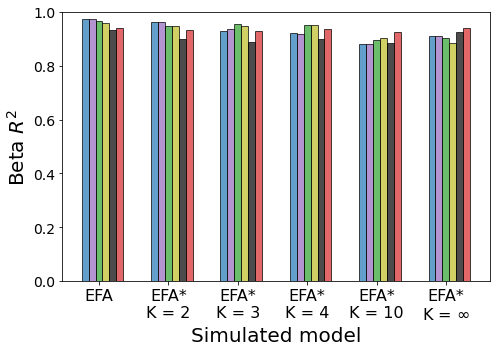

In [143]:
res = dict()
param = 'additive_var'
# param = 'percent_uncoordinated'
# metric = 'pheno'
metric = 'beta'
# metric = 'omega'
# metric = 'u'

ylab = {'pheno': r'Phenotype Prediction $R^{2}$',
        'beta': r'Beta $R^{2}$',
        'omega': r'Omega $R^{2}$',
        'u': r'Pathway $R^{2}$'}

fname_list = []
fname_list.append('./data/%s_k2/' %param)
fname_list += ['./data/%s_k%d_self/' %(param, i) for i in [2, 3, 4, 10]]
fname_list.append('./data/percent_uncoordinated_k2_self/')

for prefix in fname_list:
    for name in ['uncoordinated', 'uncoordinated_random', 
                 'coordinated_k2', 'coordinated_self_k2', 
                 'coordinated_self_k3', 'coordinated_self_k4']:    
        df = pd.read_csv(prefix + name + '.csv')
        if prefix == './data/percent_uncoordinated_k2_self/':
            idx = df.loc[:,'param'] == 1
        else:
            idx = df.loc[:,'param'] == 0.5
        acc = df[idx].loc[:, metric].mean()
        res_list = res.get(name, list())
        res_list.append(acc)
        res[name] = res_list

X = ['EFA', 'EFA*\nK = 2','EFA*\nK = 3','EFA*\nK = 4', 'EFA*\nK = 10', 'EFA*\nK = $\infty$']
  
X_axis = np.arange(len(X))

width = 0.1

fig, ax = plt.subplots(figsize=(7, 5))

ax.bar(X_axis + width * 0, res['coordinated_k2'], width, label = 'EFA', edgecolor='black', alpha=0.7, color=model_col_map['ident'])
ax.bar(X_axis + width * 1, res['coordinated_self_k2'], width, label = 'Model K=2', edgecolor='black', alpha=0.7, color=model_col_map['ce2'])
ax.bar(X_axis + width * 2, res['coordinated_self_k3'], width, label = 'Model K=3', edgecolor='black', alpha=0.7, color=model_col_map['ce3'])
ax.bar(X_axis + width * 3, res['coordinated_self_k4'], width, label = 'Model K=4', edgecolor='black', alpha=0.7, color=model_col_map['ce4'])
ax.bar(X_axis + width * 4, res['uncoordinated'], width, label = 'Uncoordinated', edgecolor='black', alpha=0.7, color=model_col_map['epf'])
ax.bar(X_axis + width * 5, res['uncoordinated_random'], width, label = 'Random Effects', edgecolor='black', alpha=0.7, color=model_col_map['epr'])
ax.set_xticks(X_axis+width*2)
ax.set_xticklabels(X)
ax.set_ylim(0, 1)

ax.set_ylabel(ylab[metric], size = 20)
ax.set_xlabel('Simulated model', size = 20)
ax.tick_params(axis='y', which='major', labelsize=14)
ax.tick_params(axis='x', which='major', labelsize=16, rotation = 0)

# fig.legend(loc='lower center', bbox_to_anchor=(0.5, 0),
#           ncol=3, fancybox=True)
# fig.subplots_adjust(bottom=0.2)
plt.tight_layout()
fig.savefig(f'./plots/model_vs_true_k_{metric}_barplot.png', transparent = True, dpi=300)
plt.show()


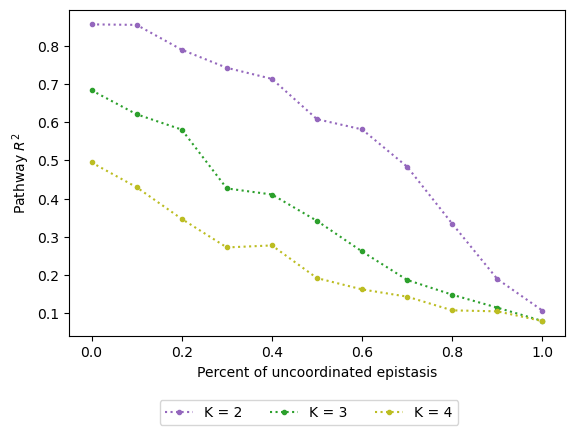

In [127]:
param = 'additive_var'
param = 'percent_uncoordinated'
# param = 'heritability'



res = dict()
fig, ax = plt.subplots()

if param == 'heritability':
    ax.set_xlabel(r'$H^{2}$')
elif param == 'additive_var':
    ax.set_xlabel(r'Percent of $H^{2}$ that is additive')
elif param == 'percent_uncoordinated':
    ax.set_xlabel(r'Percent of uncoordinated epistasis')

for i in [2, 3, 4]:
    prefix = './data/%s_k%d_self/' %(param, i)
    name = 'coordinated_self_k%d' %(i)
    df = pd.read_csv(prefix + name + '.csv')
    df = df.groupby('param').mean()

    ax.plot(df.iloc[:,4], color = model_col_map[f'ce{i}'], linestyle=':', marker='.', label=f'K = {i}')

# ax.set_xlim(0, 1.1)
# ax.set_ylim(0, 1.1)
ax.set_ylabel(r'Pathway $R^{2}$')
fig.legend(loc='lower center', bbox_to_anchor=(0.5, 0),
          ncol=num_plots, fancybox=True)
fig.subplots_adjust(bottom=0.2)
fig.savefig('./plots/%s_anchor_line.png' %(param), dpi=300)
# fig.legend((lines[0], lines[1], lines[2]), ('k=2', 'k=3', 'k=4'))

## Calibration

In [137]:
from scipy.stats import pearsonr

null = list()
name = 'dominance'
# name = 'additive'

for i in range(1, 1000+1):
    # if i == 318: continue
    fname = f'./data/{name}_perm_h2_1e-1/null/models_{i}.pkl'
    if not os.path.isfile(fname):
        print('missing: %s' %fname)
        continue
    with open(fname, 'rb') as f:

        ce = pkl.load(f)
        am = pkl.load(f)
        ep = pkl.load(f)

        # null.append(ce[0].weights[0,1] ** 2)
        # null.append(tools.evalAcc(ce[0].beta, ce[1].beta))
        null.append(tools.evalAcc(ce[0].omega, ce[1].omega))
        # null.append(tools.evalAcc(ce[0].pathways, ce[1].pathways))
        # ustat0 = (ce[0].pathways* np.array([1, -1])).sum(axis = 1)
        # ustat1 = (ce[1].pathways* np.array([1, -1])).sum(axis = 1)
        # null.append(pearsonr(ustat0, ustat1)[0] ** 2)
        # null.append(tools.evalAcc(am[0].beta, am[1].beta))
        # null.append(tools.evalAcc(ep[0].omega, ep[1].omega))

res = list()

for i in range(1, 1000+1):
    fname = f'./data/{name}_perm_h2_1e-1/models_{i}.pkl'
    if not os.path.isfile(fname):
        print('missing: %s' %fname)
        continue
    with open(fname, 'rb') as f:
        ce = pkl.load(f)
        am = pkl.load(f)
        ep = pkl.load(f)

        # res.append(ce[0].weights[0,1] ** 2)
        # res.append(tools.evalAcc(ce[0].beta, ce[1].beta))
        res.append(tools.evalAcc(ce[0].omega, ce[1].omega))
        # res.append(tools.evalAcc(ce[0].pathways, ce[1].pathways))
        # ustat0 = (ce[0].pathways* np.array([1, -1])).sum(axis = 1)
        # ustat1 = (ce[1].pathways* np.array([1, -1])).sum(axis = 1)
        # res.append(pearsonr(ustat0, ustat1)[0] ** 2)
        # res.append(tools.evalAcc(am[0].beta, am[1].beta))
        # res.append(tools.evalAcc(ep[0].omega, ep[1].omega))

In [138]:
p_thresh = np.quantile(null, 1-0.05)
np.sum([r2 > p_thresh for r2 in res])/1000

0.165

<ipython-input-140-73c3725ec195>:3: RuntimeWarning: divide by zero encountered in log10
  plt.scatter(-np.log10(np.arange(1000)/1000), -np.log10(np.sort(pvals)), marker='.')


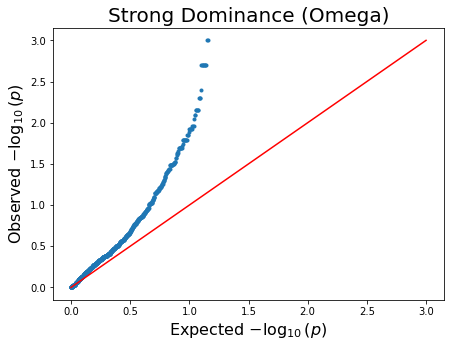

In [140]:
plt.subplots(figsize=(7, 5))
pvals = ([np.sum([null_r2 > r2 for null_r2 in null])/1000 for r2 in res])
plt.scatter(-np.log10(np.arange(1000)/1000), -np.log10(np.sort(pvals)), marker='.')
plt.plot([0, 3], [0,3], color='red')
plt.xlabel(r'Expected $-\log_{10}(p)$', fontdict={'fontsize':16})
plt.ylabel(r'Observed $-\log_{10}(p)$', fontdict={'fontsize':16})
plt.title('Strong Dominance (Omega)', fontdict={'fontsize':20})
plt.savefig('./plots/dominance_perm_omega_strong.png', dpi=300)
plt.show()


## Bootstrap Calibration

In [208]:
import numpy as np
import matplotlib.pyplot as plt
import pickle as pkl

n_sims = 500

sims = ['efa_0', 'efa_1', 'efa_10', 'efa_50', 'dominance_1', 'dominance_10', 'LD_0']
res = np.zeros((len(sims), n_sims))
median = np.zeros((len(sims), n_sims))
full_fit = np.zeros((len(sims), n_sims))
true = np.zeros((len(sims), n_sims))
bs = np.zeros((len(sims), n_sims, 500))
conv = np.zeros((len(sims), n_sims, 500), dtype = bool)
for row,sim in enumerate(sims):
    for i in range(n_sims):
        with open(f'./pkl/{sim}/repeat{i+1}.pkl', 'rb') as f:
            res[row, i] = pkl.load(f)
            median[row, i] = pkl.load(f)
            full_fit[row, i] = pkl.load(f)
            true[row, i] = pkl.load(f)
            bs[row, i] = pkl.load(f)
            conv[row, i] = pkl.load(f)
            

In [245]:
contains_zero = np.zeros((len(sims), n_sims))

for i in range(bs.shape[0]):
    for j in range(bs.shape[1]):
        lower = np.quantile(bs[i, j, conv[i, j]], 0.025)
        upper = np.quantile(bs[i, j, conv[i, j]], 0.975)
        contains_zero[i, j] = (lower <= 0) and (upper >= 0)

contains_zero_mu = contains_zero.mean(axis = 1)
contains_zero_se = np.sqrt(contains_zero_mu * (1 - contains_zero_mu)/n_sims)

concordance = (true * full_fit) > 0
concordance_mu = concordance.mean(axis = 1)
concordance_se = np.sqrt(concordance_mu * (1 - concordance_mu)/n_sims)

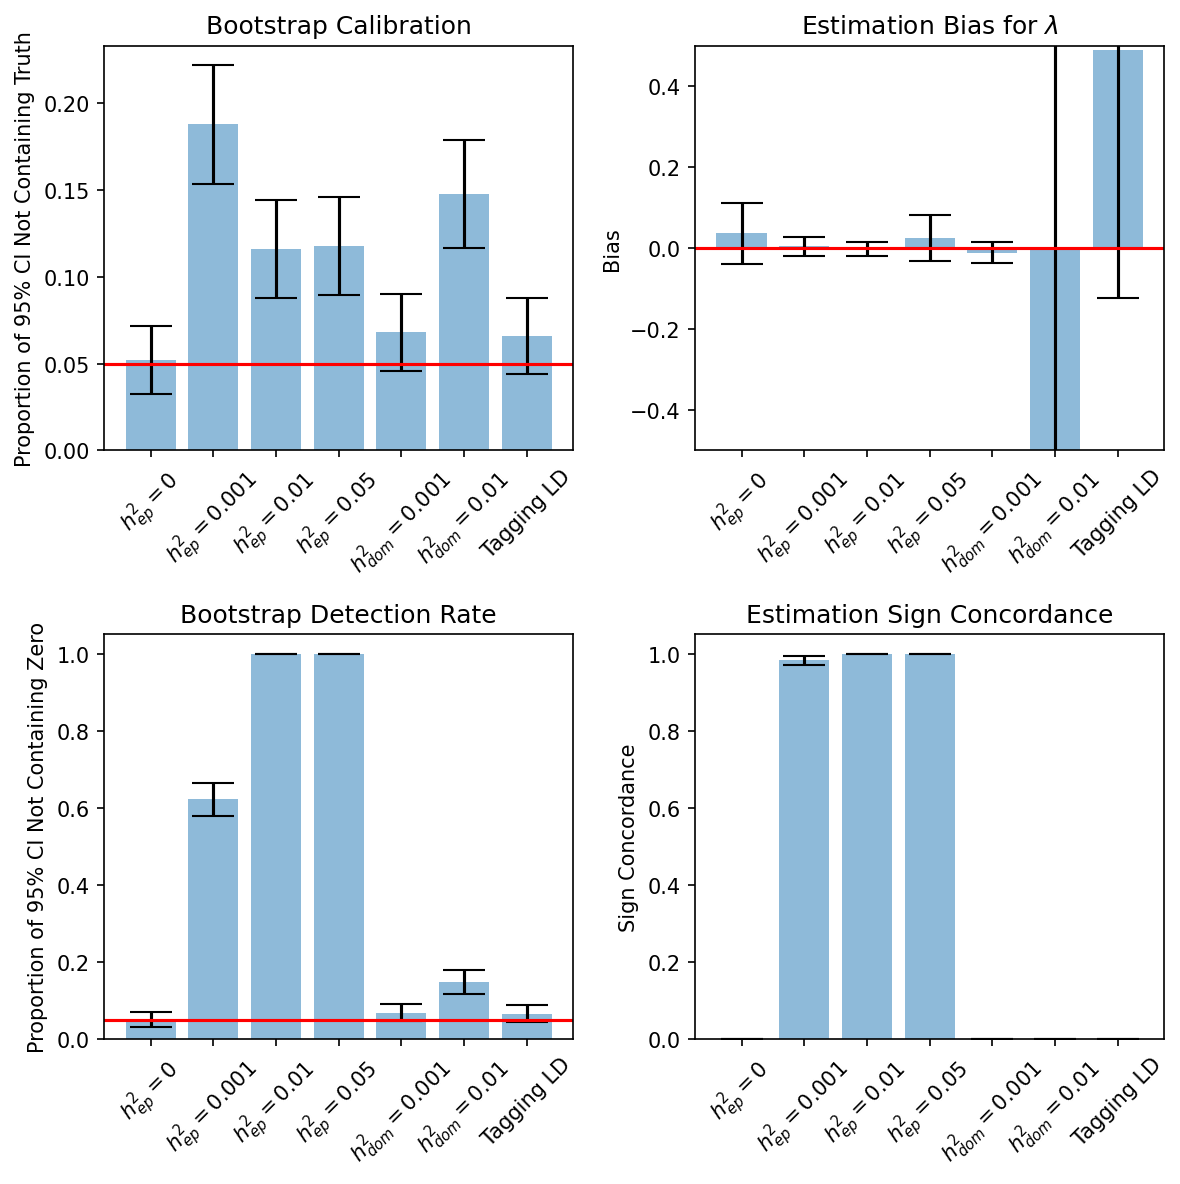

In [247]:
mu = res.mean(axis = 1)
se = np.sqrt(mu * (1 - mu)/n_sims)
# se = res.std(axis = 1)/np.sqrt(1000)

alpha = 0.5
capsize = 10
xlabs = [
    r'$h^{2}_{ep} = 0$',
    r'$h^{2}_{ep} = 0.001$',
    r'$h^{2}_{ep} = 0.01$',
    r'$h^{2}_{ep} = 0.05$',
    r'$h^{2}_{dom} = 0.001$',
    r'$h^{2}_{dom} = 0.01$',
    r'Tagging LD',
]

fig, ax = plt.subplots(2, 2, figsize = (8, 8), dpi=150)
ax[0,0].bar(np.arange(len(mu)), 1 - mu, yerr=1.96*se, alpha = alpha, capsize=capsize)
ax[0,0].set_xticks(np.arange(len(mu)), xlabs, rotation = 45)
ax[0,0].set_ylabel('Proportion of 95% CI Not Containing Truth')
ax[0,0].axhline(.05, color = 'red')
ax[0,0].set_title('Bootstrap Calibration')

bias = (true - full_fit)
bias_mu = bias.mean(axis = 1)
bias_se = bias.std(axis = 1)/np.sqrt(500)
ax[0,1].bar(np.arange(len(bias)), bias_mu, yerr = 1.96*bias_se, alpha = alpha, capsize=capsize)
ax[0,1].set_xticks(np.arange(len(bias)), xlabs, rotation = 45)
ax[0,1].set_ylim((-.5, .5))
ax[0,1].set_ylabel('Bias')
ax[0,1].axhline(0, color = 'red')
ax[0,1].set_title(r'Estimation Bias for $\lambda$')

ax[1,0].bar(np.arange(len(contains_zero_mu)), 1 - contains_zero_mu, yerr=1.96*contains_zero_se, alpha = alpha, capsize=capsize)
ax[1,0].set_xticks(np.arange(len(contains_zero_mu)), xlabs, rotation = 45)
ax[1,0].set_ylabel('Proportion of 95% CI Not Containing Zero')
ax[1,0].axhline(.05, color = 'red')
ax[1,0].set_title('Bootstrap Detection Rate')

ax[1,1].bar(np.arange(len(concordance_mu)), concordance_mu, yerr=1.96*concordance_se, alpha = alpha, capsize=capsize)
ax[1,1].set_xticks(np.arange(len(concordance_mu)), xlabs, rotation = 45)
ax[1,1].set_ylabel('Sign Concordance')
ax[1,1].set_title('Estimation Sign Concordance')

plt.tight_layout()
plt.savefig('./plots/bootstrap_supp.png', dpi=300)